In [1]:
!pip install seqeval

  Created wheel for seqeval: filename=seqeval-0.0.12-py3-none-any.whl size=7423 sha256=8901ff9b52e07baac9a1f1bdf8784b25ed9bbfae93b761c4fb49d978656a3ac8
  Stored in directory: /root/.cache/pip/wheels/dc/cc/62/a3b81f92d35a80e39eb9b2a9d8b31abac54c02b21b2d466edc
Successfully built seqeval


In [2]:
import os
import torch
import transformers

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

from tqdm import tqdm, trange
from seqeval.metrics import classification_report, f1_score
from transformers import BertTokenizer, BertConfig
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForTokenClassification, AdamW, get_linear_schedule_with_warmup 

Using TensorFlow backend.


In [3]:
base_path = "/kaggle"

# Chech if it's in kaggle environment 
if os.path.exists(base_path):
    input_path = os.path.join(base_path, "input", "entity-annotated-corpus")
    output_path = os.path.join(base_path, "working")
else:
    base_path = "data"
    input_path = base_path
    output_path = os.path.join(base_path, "submissions")


ner_dataset = os.path.join(input_path, "ner_dataset.csv")
ner = os.path.join(input_path, "ner.csv")

### Load dataset

In [4]:
df = pd.read_csv(ner_dataset, encoding="latin1")

In [5]:
df.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


### Data analysis and Data cleaning

In [6]:
df["Sentence #"].fillna(method="ffill", inplace=True)

In [7]:
df.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [8]:
words_list = list(set(df["Word"].values))

print(f"There are {len(words_list)} words.")

words_list[:10]

There are 35178 words.


['Atalay',
 'Sharm',
 'stream',
 'tobacco',
 'Dawoud',
 'Medellin',
 'line-of-control',
 'reconnaissance',
 'beds',
 'Fine']

In [9]:
tags_values = list(set(df["Tag"].values))
tags_values.append("PAD")

tag2idx = {t: i for i, t in enumerate(tags_values)}

### Prepare dataset as BERT input

In [10]:
class SentenceGetter():
    def __init__(self, data):
        self.data = data
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        
        self._split_sentence_and_labels()
        
    def _split_sentence_and_labels(self):
        self.sentences = []
        self.labels = []
        for sentence in self.grouped:
            tmp_sentence, tmp_tag = [], []
            for word, _, tag in sentence:
                tmp_sentence.append(word)
                tmp_tag.append(tag)

            self.sentences.append(tmp_sentence)
            self.labels.append(tmp_tag)

In [11]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    sentence_labels = []
    for word, label in zip(sentence, text_labels):
        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        sentence_labels.extend([label] * n_subwords)
    
    return tokenized_sentence, sentence_labels

In [12]:
class DataSet():
    def __init__(self, sentence_getter, tokenizer, max_len, tag2idx):
        # Tokenize sentences
        self.tokens = []
        self.labels = []
        for sentences, labels in zip(sentence_getter.sentences, sentence_getter.labels):
            tok, lab = tokenize_and_preserve_labels(sentences, labels)
            
            self.tokens.append(["[CLS]"] + tok)
            self.labels.append(["O"] + lab)
        
        # Convert tokens to ids
        self.input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in self.tokens], 
                                       maxlen=max_len, dtype="long", truncating="post", padding="post")
        
        # Convert tags to ids
        self.tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in self.labels], maxlen=max_len, 
                                  value=tag2idx["PAD"], padding="post", dtype="long", truncating="post")
        
        pad_tok = tokenizer.vocab["[PAD]"]
        sep_tok = tokenizer.vocab["[SEP]"]
        o_lab = tag2idx["O"]
        # Adding [SEP] and O for mark the end of sentence or nothing for splited sentences
        for voc_ids, tag_ids in zip(self.input_ids, self.tags):
            if voc_ids[-1] == pad_tok:
                continue
            else:
                voc_ids[-1] = sep_tok
                tag_ids[-1] = o_lab

        # Place a mask (zero) over the padding tokens
        self.attention_masks = [[float(i != 0.0) for i in ii] for ii in self.input_ids]

#### Download BERT tokenizer

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [14]:
sentence_getter = SentenceGetter(df)
dataset = DataSet(sentence_getter, tokenizer, 32, tag2idx)

#### Split data into train and validation

In [15]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(dataset.input_ids, dataset.tags,
                                                            random_state=2018, test_size=0.1)

tr_masks, val_masks, _, _ = train_test_split(dataset.attention_masks, dataset.input_ids,
                                             random_state=2018, test_size=0.1)

In [16]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)

tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)

tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [17]:
batch_size = 32

train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_size)

#### Donwload pre-trained BERT model

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions=False,
    output_hidden_states=False
)

In [20]:
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

#### Model fine-tuning

In [21]:
full_finetuning = True
if full_finetuning:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

#### Create the learning rate scheduler.

In [22]:
epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

### Training and validation

In [23]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [24]:
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    model.train()
    
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        # Clear previously gradients.
        model.zero_grad()
        
        # forward pass
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        
        total_loss += loss.item()
        # Clip the norm of the gradient (for prevent "exploding gradients")
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        
        # Update parameters
        optimizer.step()
        
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    loss_values.append(avg_train_loss)
    
    # ========================================
    #               Validation
    # ========================================
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Not to compute or store gradients,
        with torch.no_grad():
            # Forward pass.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch.
        eval_loss += outputs[0].mean().item()
        eval_accuracy += flat_accuracy(logits, label_ids)
        
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1

    # Compute statistics
    eval_loss = eval_loss / nb_eval_steps
    validation_loss_values.append(eval_loss)
    
    pred_tags = [tags_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tags_values[l_i] != "PAD"]
    valid_tags = [tags_values[l_i] for l in true_labels
                                  for l_i in l if tags_values[l_i] != "PAD"]
    
    # Show values
    print(f"Validation loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy / nb_eval_steps}")
    print(f"Classification report {classification_report(valid_tags, pred_tags)}")
    print(f"Validation F1-Score: {f1_score(pred_tags, valid_tags)}")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.17833303936858633
Validation loss: 0.13170740142464638
Validation Accuracy: 0.7390066964285714
Classification report            precision    recall  f1-score   support

      per       0.75      0.84      0.79      2707
      geo       0.82      0.88      0.85      5435
      org       0.78      0.65      0.71      3426
      tim       0.87      0.82      0.84      2142
      gpe       0.96      0.91      0.94      1709
      art       1.00      0.03      0.07        86
      nat       0.39      0.22      0.28        32
      eve       0.44      0.22      0.29        32

micro avg       0.82      0.81      0.81     15569
macro avg       0.82      0.81      0.81     15569



Epoch:  33%|███▎      | 1/3 [03:15<06:30, 195.47s/it]

Validation F1-Score: 0.814425001614257
Average train loss: 0.10224364777050741
Validation loss: 0.11721043859918913
Validation Accuracy: 0.74228515625
Classification report            precision    recall  f1-score   support

      per       0.80      0.82      0.81      2707
      geo       0.85      0.89      0.87      5435
      org       0.76      0.70      0.73      3426
      tim       0.84      0.84      0.84      2142
      gpe       0.95      0.92      0.94      1709
      art       0.12      0.03      0.05        86
      nat       0.70      0.22      0.33        32
      eve       0.42      0.25      0.31        32

micro avg       0.83      0.83      0.83     15569
macro avg       0.83      0.83      0.83     15569



Epoch:  67%|██████▋   | 2/3 [06:28<03:14, 194.62s/it]

Validation F1-Score: 0.8283127678082411
Average train loss: 0.07734511000241634
Validation loss: 0.11983026357988516
Validation Accuracy: 0.7429678199404762
Classification report            precision    recall  f1-score   support

      per       0.81      0.82      0.82      2707
      geo       0.84      0.90      0.87      5435
      org       0.77      0.71      0.74      3426
      tim       0.86      0.83      0.84      2142
      gpe       0.96      0.93      0.94      1709
      art       0.47      0.22      0.30        86
      nat       0.48      0.34      0.40        32
      eve       0.36      0.38      0.37        32

micro avg       0.83      0.83      0.83     15569
macro avg       0.83      0.83      0.83     15569



Epoch: 100%|██████████| 3/3 [09:40<00:00, 193.45s/it]

Validation F1-Score: 0.8322505949700907


In [ ]:
model_path = os.path.join(output_path, "trained_bert.pt")
torch.save(model.state_dict(), model_path)

### Plot learning curve

In [25]:
def plot_learning_curve(training_loss, validation_loss):
    plt.figure(figsize=(12, 8))
    
    plt.plot(training_loss, 'b-o', label="training loss")
    plt.plot(validation_loss, 'r-o', label="validation loss")

    plt.title("Learning curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

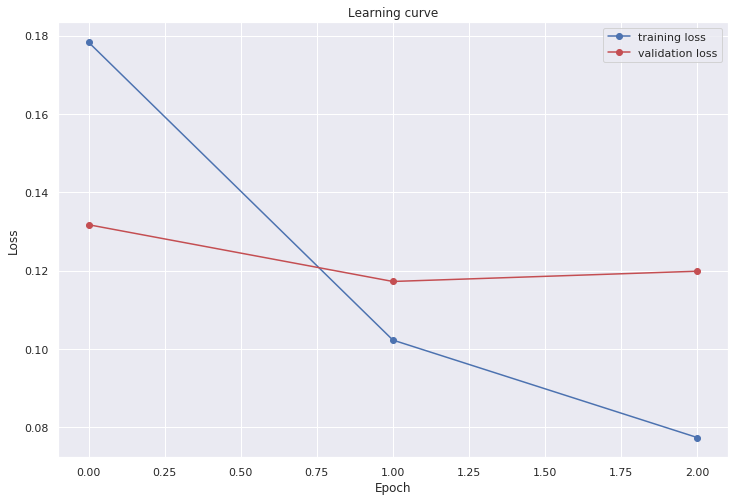

In [26]:
plot_learning_curve(loss_values, validation_loss_values)

### Predictions

In [27]:
def prediction(sentence):
    tokenized_sentence = tokenizer.encode(sentence)
    input_ids = torch.tensor([tokenized_sentence]).cuda()

    with torch.no_grad():
        output = model(input_ids)
    label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

    tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
    new_tokens, new_labels = [], []
    for token, label_idx in zip(tokens, label_indices[0]):
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            new_labels.append(tags_values[label_idx])
            new_tokens.append(token)
   
    for token, label in zip(new_tokens, new_labels):
        print("{}\t{}".format(label, token))

In [28]:
test_sentence = """
Mr. Trump’s tweets began just moments after a Fox News report by Mike Tobin, a 
reporter for the network, about protests in Minnesota and elsewhere."""

prediction(test_sentence)

O	[CLS]
B-per	Mr
B-per	.
I-per	Trump
O	’
O	s
O	tweets
O	began
O	just
O	moments
O	after
O	a
B-org	Fox
I-org	News
O	report
O	by
B-per	Mike
I-per	Tobin
O	,
O	a
O	reporter
O	for
O	the
O	network
O	,
O	about
O	protests
O	in
B-geo	Minnesota
O	and
O	elsewhere
O	.
O	[SEP]


In [29]:
test_sentence = """
The New York Times (sometimes abbreviated as the NYT and NYTimes) is an American newspaper based in New York City with worldwide 
influence and readership.[6][7][8] Founded in 1851, the paper has won 130 Pulitzer Prizes, more than any other newspaper."""

prediction(test_sentence)

O	[CLS]
O	The
B-org	New
I-org	York
I-org	Times
O	(
O	sometimes
O	abbreviated
O	as
O	the
B-org	NYT
O	and
B-org	NYTimes
O	)
O	is
O	an
B-gpe	American
O	newspaper
O	based
O	in
B-geo	New
I-geo	York
I-geo	City
O	with
O	worldwide
O	influence
O	and
O	readership
O	.
O	[
O	6
O	]
O	[
O	7
O	]
O	[
O	8
O	]
O	Founded
O	in
B-tim	1851
O	,
O	the
O	paper
O	has
O	won
O	130
B-org	Pulitzer
I-org	Prizes
O	,
O	more
O	than
O	any
O	other
O	newspaper
O	.
O	[SEP]


In [30]:
test_sentence = "UK Prime Minister Boris Johnson is expected to explain any changes to lockdown measures and launch a threat level alert system."

prediction(test_sentence)

O	[CLS]
B-org	UK
B-per	Prime
I-per	Minister
I-per	Boris
I-per	Johnson
O	is
O	expected
O	to
O	explain
O	any
O	changes
O	to
O	lockdown
O	measures
O	and
O	launch
O	a
O	threat
O	level
O	alert
O	system
O	.
O	[SEP]


In [31]:
test_sentence = "In South Korea, renewed restrictions are imposed after a series of transmissions linked to Seoul's leisure district."

prediction(test_sentence)

O	[CLS]
O	In
B-geo	South
I-geo	Korea
O	,
O	renewed
O	restrictions
O	are
O	imposed
O	after
O	a
O	series
O	of
O	transmissions
O	linked
O	to
B-geo	Seoul
O	'
O	s
O	leisure
O	district
O	.
O	[SEP]
